In [82]:
pip install helperfns -q

Note: you may need to restart the kernel to use updated packages.


In [83]:
import torch
import random
import os
import time
import tqdm

import torch.nn as nn
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils import data
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split

from helperfns.tables import tabulate_data
from helperfns.utils import hms_string


torch.__version__

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\crisp\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\words.zip.


'2.2.2'

In [84]:
SEED = 42

random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True

In [85]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [86]:
base_dir = "nutrients"
csv_file = os.path.join(base_dir, 'data.csv')
images_file = os.path.join(base_dir, 'images')

In [87]:
dataframe = pd.read_csv(csv_file)
dataframe.head()

,index,image,carbs,fat,fibre,kcal,protein,salt,saturates,sugars
0,1,recipe-image-legacy-id-46013_11-99b8eda.jpg,30.0,11.0,2.0,275.0,17.0,1.99,6.0,4.0
1,2,recipe-image-legacy-id-743466_11-e87df17.jpg,38.0,7.0,2.0,240.0,8.0,1.37,2.0,1.0
2,3,recipe-image-legacy-id-1119465_11-4aebb21.jpg,22.0,17.0,1.0,294.0,13.0,1.50,9.0,1.0
3,4,recipe-image-legacy-id-1201816_10-7f0a38f.jpg,32.0,9.0,2.0,250.0,12.0,1.00,5.0,3.0
4,9,recipe-image-legacy-id-1025484_11-f56ab42.jpg,25.0,11.0,1.0,218.0,6.0,0.60,6.0,1.0


In [88]:
dataframe.iloc[:,2: ]

,carbs,fat,fibre,kcal,protein,salt,saturates,sugars
0,30.0,11.0,2.0,275.0,17.0,1.99,6.0,4.0
1,38.0,7.0,2.0,240.0,8.0,1.37,2.0,1.0
2,22.0,17.0,1.0,294.0,13.0,1.50,9.0,1.0
3,32.0,9.0,2.0,250.0,12.0,1.00,5.0,3.0
4,25.0,11.0,1.0,218.0,6.0,0.60,6.0,1.0
...,...,...,...,...,...,...,...,...
1253,30.0,22.0,14.0,391.0,11.0,1.10,13.0,18.0
1254,21.0,3.0,5.0,149.0,6.0,0.39,0.5,12.0
1255,22.0,3.0,4.0,137.0,2.0,0.12,2.0,21.0
1256,11.0,4.0,3.0,84.0,2.0,0.03,1.0,10.0


In [144]:
class RecipeImageDataset(data.Dataset):
    def __init__(self, data, transform=None):
        self.transform = transform
        self.images = data.image.values
        self.nutrients = data.iloc[:,2: ].values
            
    def __len__(self):
        return len(self.images)
        
    def __getitem__(self, index):
        try:
            Image.open(os.path.join(images_file, self.images[index])).convert('RGB')
        except Exception:
            index = index + 1
        image_path = os.path.join(images_file, self.images[index])
        image = Image.open(image_path).convert('RGB')
        sample = image
        if self.transform:
            sample = self.transform(sample)
        return sample, self.nutrients[index]

    def __repr__(self)->str:
        return "RecipeImageDataset"
    def __str__(self)->str:
        return 'RecipeImageDataset'

In [104]:
train, test = train_test_split(dataframe, test_size=.13, random_state=SEED)
len(train), len(test)

(1094, 164)

In [105]:
mean = std = .5

image_transforms = {
    "train": transforms.Compose([
       transforms.Resize([96,96]),
       transforms.RandomRotation(5),
       transforms.RandomHorizontalFlip(.5),
       transforms.RandomCrop(96, padding=2),
       transforms.ToTensor(),
       transforms.Grayscale(
         num_output_channels = 1
       ),
       transforms.Normalize(mean=[mean], std=[std], inplace=False)                         
    ]),
    "test": transforms.Compose([
        transforms.Resize([96,96]),
        transforms.ToTensor(),
        transforms.Grayscale(
         num_output_channels =1
       ),
        transforms.Normalize(mean=[mean], std=[std], inplace=False)
    ])
}

In [106]:
train_dataset = RecipeImageDataset(
    train,
    transform = image_transforms['train'],
)
test_dataset = RecipeImageDataset(
    test,
    transform = image_transforms['test'],
)

In [107]:
train_dataset[2]

(tensor([[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [ 0.8017,  0.8017,  0.8054,  ..., -1.0000, -1.0000, -1.0000],
          [ 0.8054,  0.8054,  0.8132,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000,  0.8663,  0.8663,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]]),
 array([ 13.  ,  14.  ,   1.  , 324.  ,  36.  ,   0.56,   6.  ,   1.  ]))

In [108]:
len(train_dataset), len(test_dataset)

(1094, 164)

In [109]:
def plot_images(images, cols=5):
  rows = 4
  fig = plt.figure()
  fig.set_size_inches(cols * 2, rows * 2)
  for i, (image, _) in enumerate(images):
      plt.subplot(rows, cols, i + 1)
      plt.axis('off')
      plt.imshow(image.view(96, 96), cmap="gray")
      plt.title("Image {}".format(i+1), color ='k', fontsize=8 )

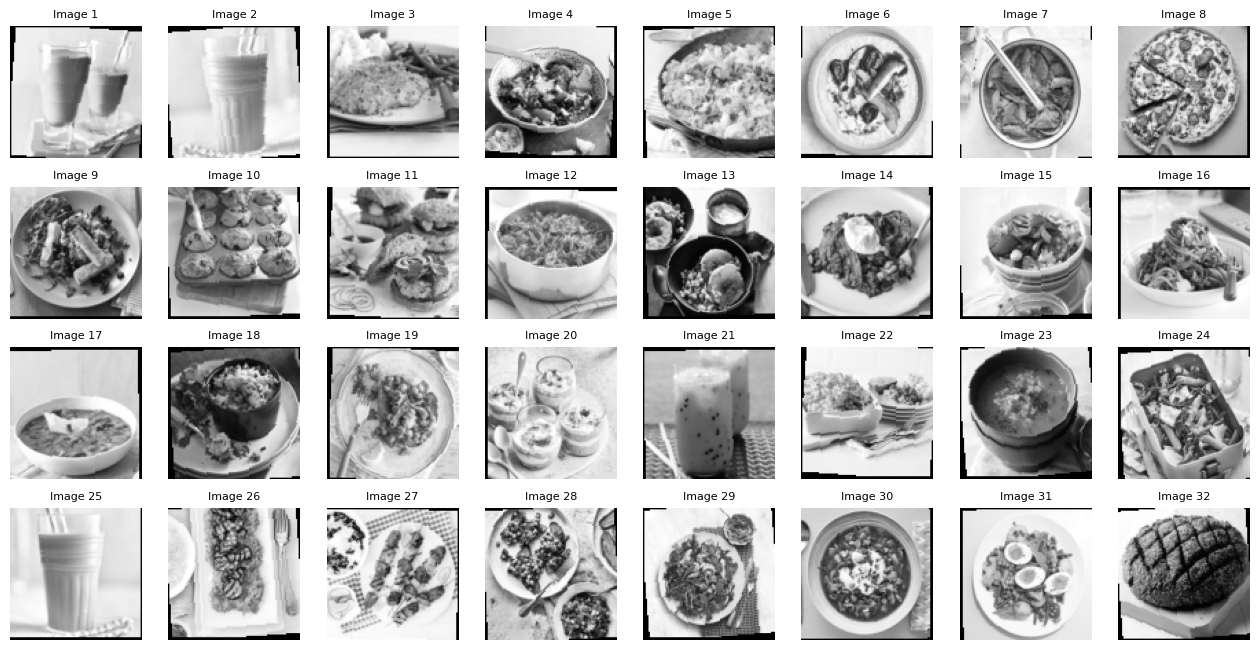

In [110]:
plot_images([train_dataset[i] for i in range(32)],  cols=8)

In [163]:
BATCH_SIZE = 50
train_iterator = data.DataLoader(train_dataset,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE
                                 )
test_iterator = data.DataLoader(test_dataset,
                                 shuffle=False,
                                 batch_size=BATCH_SIZE
                                 )

In [112]:
class MLP(nn.Module):
  def __init__(self, input_dim, output_dim, dropout=.5):
    super(MLP, self).__init__()
    self.classifier = nn.Sequential(
        nn.Linear(input_dim, 250),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(250, 100),
        nn.ReLU(),
        nn.Dropout(dropout),
        nn.Linear(100, output_dim)
    )

  def forward(self, x):
    # x = [batch size, height, width]
    batch_size = x.shape[0]
    x = x.view(batch_size, -1)
    # x = [batch size, height * width]
    x = self.classifier(x) # x = [batch_size, output_dim]
    return x

In [113]:
INPUT_DIM = 96 * 96
OUTPUT_DIM = 8
dropout = .5
features_mlp = MLP(INPUT_DIM, OUTPUT_DIM, dropout).to(device)
features_mlp

MLP(
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=250, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=250, out_features=100, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=100, out_features=8, bias=True)
  )
)

In [114]:
optimizer = torch.optim.SGD(features_mlp.parameters(), lr=0.01)
criterion = nn.L1Loss()

In [123]:

def train(model, iterator, optimizer, criterion, device):
  epoch_loss =  0
  model.train()
  for (x, y) in iterator:
    # features and labels to the device
    x = x.to(device)
    y = y.to(device)
    # Zero the gradients
    optimizer.zero_grad()
    y_pred = model(x)
    loss = criterion(y_pred, y)
    # Backward propagate
    loss.backward()
    # Update the weights
    optimizer.step()
    epoch_loss +=loss.item()
  return epoch_loss/len(iterator)

def evaluate(model, iterator, criterion, device):
  epoch_loss = 0
  model.eval()
  with torch.no_grad():
    for (x, y) in iterator:
      x = x.to(device)
      y = y.to(device)
      y_pred = model(x)
    
      loss = criterion(y_pred, y)
      epoch_loss += loss.item()
  return epoch_loss/len(iterator)

train(features_mlp, train_iterator, optimizer, criterion, device)

56.08622163460184

In [124]:

EPOCHS = 20
best_valid_loss = float('inf')
MODEL_NAME = "mlp.pt"
column_names = ["Set", "Loss", "ETA (time)"]
last_saved_epoch = 1

training_start = time.time()
for epoch in range(EPOCHS):
  start = time.time()

  train_loss = train(features_mlp, train_iterator, optimizer, criterion, device)
  valid_loss = evaluate(features_mlp, test_iterator, criterion, device)

  save_status = "(not saving)"
  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    save_status = "(saving)"
    last_saved_epoch = epoch + 1
    torch.save(features_mlp.state_dict(), MODEL_NAME)
  end = time.time()
  data_rows = [
      ["Train", f'{train_loss:.3f}',  hms_string(end-start)],
      ["Validation", f'{valid_loss:.3f}', ""]
  ]
  title = f"EPOCH {epoch+1:02}/{EPOCHS}: {save_status}"
  tabulate_data(column_names, data_rows, title)
training_end = time.time()




EPOCH 01/20: (saving)
+------------+--------+------------+
| Set        |   Loss | ETA (time) |
+------------+--------+------------+
| Train      | 51.232 | 0:00:42.87 |
| Validation | 43.770 |            |
+------------+--------+------------+
EPOCH 02/20: (saving)
+------------+--------+------------+
| Set        |   Loss | ETA (time) |
+------------+--------+------------+
| Train      | 38.946 | 0:00:47.46 |
| Validation | 34.494 |            |
+------------+--------+------------+
EPOCH 03/20: (saving)
+------------+--------+------------+
| Set        |   Loss | ETA (time) |
+------------+--------+------------+
| Train      | 34.358 | 0:00:42.46 |
| Validation | 33.307 |            |
+------------+--------+------------+
EPOCH 04/20: (not saving)
+------------+--------+------------+
| Set        |   Loss | ETA (time) |
+------------+--------+------------+
| Train      | 32.084 | 0:00:46.37 |
| Validation | 36.614 |            |
+------------+--------+------------+
EPOCH 05/20: (not sa

KeyboardInterrupt: 

In [127]:
features_mlp.load_state_dict(torch.load(MODEL_NAME))

test_loss = evaluate(features_mlp, test_iterator, criterion, device)
title = "Model Evaluation Summary"
data_rows = [["Test", f'{test_loss:.3f}', ""]]

tabulate_data(column_names, data_rows, title)

Model Evaluation Summary
+------+--------+------------+
| Set  |   Loss | ETA (time) |
+------+--------+------------+
| Test | 33.307 |            |
+------+--------+------------+


In [128]:
for image, nutrients in test_iterator:
    pass;
    break

In [134]:
with torch.no_grad():
    preds = torch.softmax(features_mlp(image), dim=0)

print(preds[:2])
nutrients[:2]

tensor([[2.5624e-03, 4.0909e-02, 4.0043e-02, 2.5580e-21, 3.1054e-02, 2.7281e-05,
         2.4816e-02, 3.1257e-02],
        [1.2404e-06, 3.6500e-03, 3.3206e-03, 0.0000e+00, 1.1712e-03, 1.6472e-04,
         2.3084e-02, 1.4367e-03]])


tensor([[5.8000e+01, 1.8000e+01, 5.0000e+00, 3.9900e+02, 1.1000e+01, 8.6000e-01,
         2.0000e+00, 1.4000e+01],
        [4.6000e+01, 4.5000e+01, 1.0000e+00, 6.0300e+02, 7.0000e+00, 1.7000e-01,
         2.5000e+01, 4.2000e+01]], dtype=torch.float64)

In [135]:
from torchvision import models

In [142]:
image_transforms = {
    "train": transforms.Compose([
        transforms.Resize([224,224]), 
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
    ]),
    "test":transforms.Compose([
        transforms.Resize([224,224]), 
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
    ])
}

In [145]:
train, test = train_test_split(dataframe, test_size=.13, random_state=SEED)
train_dataset = RecipeImageDataset(
    train,
    transform = image_transforms['train'],
)
test_dataset = RecipeImageDataset(
    test,
    transform = image_transforms['test'],
)

In [155]:
model_ft = models.resnet18(pretrained=True)
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [156]:
IN_FEATURES = model_ft.fc.in_features 
OUTPUT_DIM = 8

print(OUTPUT_DIM)
fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)
fc

8


Linear(in_features=512, out_features=8, bias=True)

In [157]:
for param in model_ft.parameters():
  param.requires_grad = False

In [158]:
def count_params(model):
     total_params = sum([p.numel() for p in model.parameters()])
     trainable_params = sum([p.numel() for p in model.parameters() if p.requires_grad])
     tabulate_data(["","Parameters"], 
           [["total parameters", f'{total_params:,}'],
            ["trainable parameters", f'{trainable_params:,}']],
           "MODEL PARAMETERS"
           )
count_params(model_ft)
    

MODEL PARAMETERS
+----------------------+------------+
|                      | Parameters |
+----------------------+------------+
| total parameters     | 11,689,512 |
| trainable parameters |          0 |
+----------------------+------------+


In [160]:
model_ft.fc = fc

In [161]:
model_ft.fc.requires_grad = True
count_params(model_ft)

MODEL PARAMETERS
+----------------------+------------+
|                      | Parameters |
+----------------------+------------+
| total parameters     | 11,180,616 |
| trainable parameters |      4,104 |
+----------------------+------------+


In [165]:
def train(model, iterator, optimizer, criterion, device):
  epoch_loss =  0
  model.train()
  for (x, y) in iterator:
    # features and labels to the device
    x = x.to(device)
    y = y.to(device)
    # Zero the gradients
    optimizer.zero_grad()
    y_pred = model(x)
    loss = criterion(y_pred, y)
    # Backward propagate
    loss.backward()
    # Update the weights
    optimizer.step()
    epoch_loss +=loss.item()
  return epoch_loss/len(iterator)

def evaluate(model, iterator, criterion, device):
  epoch_loss = 0
  model.eval()
  with torch.no_grad():
    for (x, y) in iterator:
      x = x.to(device)
      y = y.to(device)
      y_pred = model(x)
    
      loss = criterion(y_pred, y)
      epoch_loss += loss.item()
  return epoch_loss/len(iterator)


In [167]:
optimizer = torch.optim.SGD(model_ft.parameters())
criterion = nn.L1Loss()

In [168]:
EPOCHS = 20
best_valid_loss = float('inf')
MODEL_NAME = "mlp-1.pt"
column_names = ["Set", "Loss", "ETA (time)"]
last_saved_epoch = 1

training_start = time.time()
for epoch in range(EPOCHS):
  start = time.time()

  train_loss = train(model_ft, train_iterator, optimizer, criterion, device)
  valid_loss = evaluate(model_ft, test_iterator, criterion, device)

  save_status = "(not saving)"
  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    save_status = "(saving)"
    last_saved_epoch = epoch + 1
    torch.save(features_mlp.state_dict(), MODEL_NAME)
  end = time.time()
  data_rows = [
      ["Train", f'{train_loss:.3f}',  hms_string(end-start)],
      ["Validation", f'{valid_loss:.3f}', ""]
  ]
  title = f"EPOCH {epoch+1:02}/{EPOCHS}: {save_status}"
  tabulate_data(column_names, data_rows, title)
training_end = time.time()

EPOCH 01/20: (saving)
+------------+--------+------------+
| Set        |   Loss | ETA (time) |
+------------+--------+------------+
| Train      | 57.312 | 0:03:12.11 |
| Validation | 53.508 |            |
+------------+--------+------------+
EPOCH 02/20: (saving)
+------------+--------+------------+
| Set        |   Loss | ETA (time) |
+------------+--------+------------+
| Train      | 56.401 | 0:03:11.76 |
| Validation | 52.693 |            |
+------------+--------+------------+
EPOCH 03/20: (saving)
+------------+--------+------------+
| Set        |   Loss | ETA (time) |
+------------+--------+------------+
| Train      | 55.630 | 0:03:35.10 |
| Validation | 51.988 |            |
+------------+--------+------------+
EPOCH 04/20: (saving)
+------------+--------+------------+
| Set        |   Loss | ETA (time) |
+------------+--------+------------+
| Train      | 55.012 | 0:03:42.49 |
| Validation | 51.364 |            |
+------------+--------+------------+


KeyboardInterrupt: 

In [170]:
# model_ft.load_state_dict(torch.load(MODEL_NAME))

test_loss = evaluate(model_ft, test_iterator, criterion, device)
title = "Model Evaluation Summary"
data_rows = [["Test", f'{test_loss:.3f}', ""]]

tabulate_data(column_names, data_rows, title)

Model Evaluation Summary
+------+--------+------------+
| Set  |   Loss | ETA (time) |
+------+--------+------------+
| Test | 51.333 |            |
+------+--------+------------+


In [172]:
for image, nutrients in test_iterator:
    pass;
    break

In [173]:
with torch.no_grad():
    preds = torch.softmax(model_ft(image), dim=0)

print(preds[:2])
nutrients[:2]

tensor([[0.0078, 0.0108, 0.0191, 0.0110, 0.0114, 0.0192, 0.0191, 0.0154],
        [0.0132, 0.0187, 0.0310, 0.0373, 0.0228, 0.0145, 0.0147, 0.0358]])


tensor([[5.8000e+01, 1.8000e+01, 5.0000e+00, 3.9900e+02, 1.1000e+01, 8.6000e-01,
         2.0000e+00, 1.4000e+01],
        [4.6000e+01, 4.5000e+01, 1.0000e+00, 6.0300e+02, 7.0000e+00, 1.7000e-01,
         2.5000e+01, 4.2000e+01]], dtype=torch.float64)